In [1]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import SGD
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data_folder = 'dataset/'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_labels = fmnist.targets

C:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 28 * 28)
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

In [5]:
def get_data():
    train_dataset = FMNISTDataset(tr_images, tr_labels)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    return train_loader

In [6]:
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)
            ).to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_function, optimizer

In [7]:
def train_batch(x, y, model, optimizer, loss_function):
    model.train()
    prediction = model(x)
    batch_loss = loss_function(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [8]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [9]:
train_loader = get_data()
model, loss_function, optimizer = get_model()
losses , accuracies = [], []

for epoch in range(5):
    print(f"Current epoch: {epoch}")
    
    epoch_lossses, epoch_accuracies = [], []
    for batch in train_loader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)
        epoch_lossses.append(batch_loss)
    epoch_loss = np.mean(epoch_lossses)
    
    for batch in train_loader:
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)    
    
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

Current epoch: 0
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4


<ipython-input-10-be73c6d465d6>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{(x * 100):.0f}' for x in plt.gca().get_yticks()])


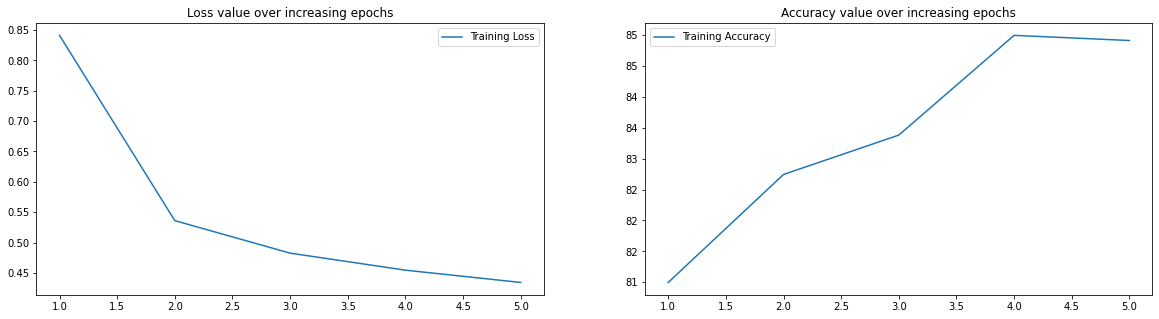

In [10]:
epochs = np.arange(5) + 1

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Loss value over increasing epochs")
plt.plot(epochs, losses, label='Training Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label="Training Accuracy")
plt.gca().set_yticklabels([f'{(x * 100):.0f}' for x in plt.gca().get_yticks()])
plt.legend();